In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

from sympy import Symbol, Point2D
from matplotlib.animation import FuncAnimation, PillowWriter

In [2]:
t = Symbol('t')

In [3]:
a_t_max = 10.0
a_n_max = 6.0
v_max = 1.5

x_min = 0
x_max = 4

A = 1
O_m = 3
theta_0 = 0.2

steps = 500
t_start = 0
t_end = 6

In [4]:
x = Symbol('x')
y = A * sp.sin(O_m * x + theta_0)

In [5]:
k = sp.diff(sp.diff(y)) / (sp.sqrt(1 + sp.diff(y)**2))**3

In [6]:
x_i = np.linspace(0, 4, steps)
y_i = np.asarray([A * np.sin(O_m * i + theta_0) for i in x_i])
k_i = np.asarray([k.subs(x, i).evalf() for i in x_i])
s_i = np.array([0] * steps, dtype=float)
for i in range(1, steps):
    s_i[i] = s_i[i - 1] + np.linalg.norm([x_i[i] - x_i[i - 1], y_i[i] - y_i[i - 1]])

In [7]:
def get_v_i(acc_steps, dec_steps): 
    v_i = [np.min([v_max, np.sqrt(a_n_max / np.abs(float(i)))]) for i in k_i[acc_steps:steps - dec_steps]]
    v_i = np.append(np.linspace(0, v_i[0], acc_steps), np.append(v_i, [v_i[-1] - temp**2 for temp in np.linspace(0, np.sqrt(v_i[-1]), dec_steps)]))
    return v_i

In [8]:
v_max_i = get_v_i(0, 12)

In [9]:
needs_polishing = []
for i in range(steps - 1):
    if v_max_i[i] == 1.5 and v_max_i[i + 1] < v_max_i[i]:
        needs_polishing.append(i)
needs_polishing.pop()
polish_pre_steps = 6
polish_post_steps = 5
for i in needs_polishing:
    for j in range(-polish_pre_steps + 1,  polish_post_steps)[::-1]:
        v_max_i[i + j - 1] = (v_max_i[i + j - 1] + v_max_i[i + j]) / 2
    dv = v_max_i[i - polish_pre_steps]  - v_max_i[i + 2]

In [10]:
v_i = np.array([0] * steps, dtype=float)
dt_i = np.array([0] * steps, dtype=float)

In [11]:
for i in range(1, steps):
    if np.abs(v_max_i[i] - v_i[i - 1]) < 1e-6:
        v_i[i] = v_i[i - 1]
        dt_i[i] = (s_i[i] - s_i[i - 1]) / v_i[i]
        continue

    if v_max_i[i] > v_i[i - 1]:
        dt_i[i] = np.max(sp.solve(a_t_max * t**2 + v_i[i-1] * t - (s_i[i] - s_i[i - 1])))
        v_i[i] = v_i[i - 1] + dt_i[i] * a_t_max
        
        if v_i[i] > v_max_i[i]:
            dt1 = np.max(sp.solve(v_i[i - 1] + a_t_max * t - v_max))
            st1 = v_i[i - 1] * dt1 + a_t_max * dt1 * dt1
            st2 = s_i[i] - s_i[i - 1] - st1
            dt2 = st2 / v_max
            
            dt_i[i] = dt1 + dt2
            v_i[i] = v_max_i[i]

        continue

    

    if v_max_i[i] < v_i[i - 1]:
        dt1 = (v_i[i - 1] - v_max_i[i]) / a_t_max
        v_i[i] = v_i[i - 1] - a_t_max * dt1
        st1 = v_i[i - 1] * dt1 + a_t_max * dt1 * dt1
        st2 = s_i[i] - s_i[i - 1] - st1

        if v_i[i] < 1e-6:
            dt_i[i] = dt1
            v_i[i] = 0
        else:
            dt2 = st2 / v_i[i]
            dt_i[i] = dt1 + dt2
        continue

        

    

In [12]:
np.sum(dt_i)

6.116368188147732

In [13]:

a_i = np.asarray([(v_i[i] - v_i[i - 1]) / dt_i[i] for i in range(1, steps)] + [0])

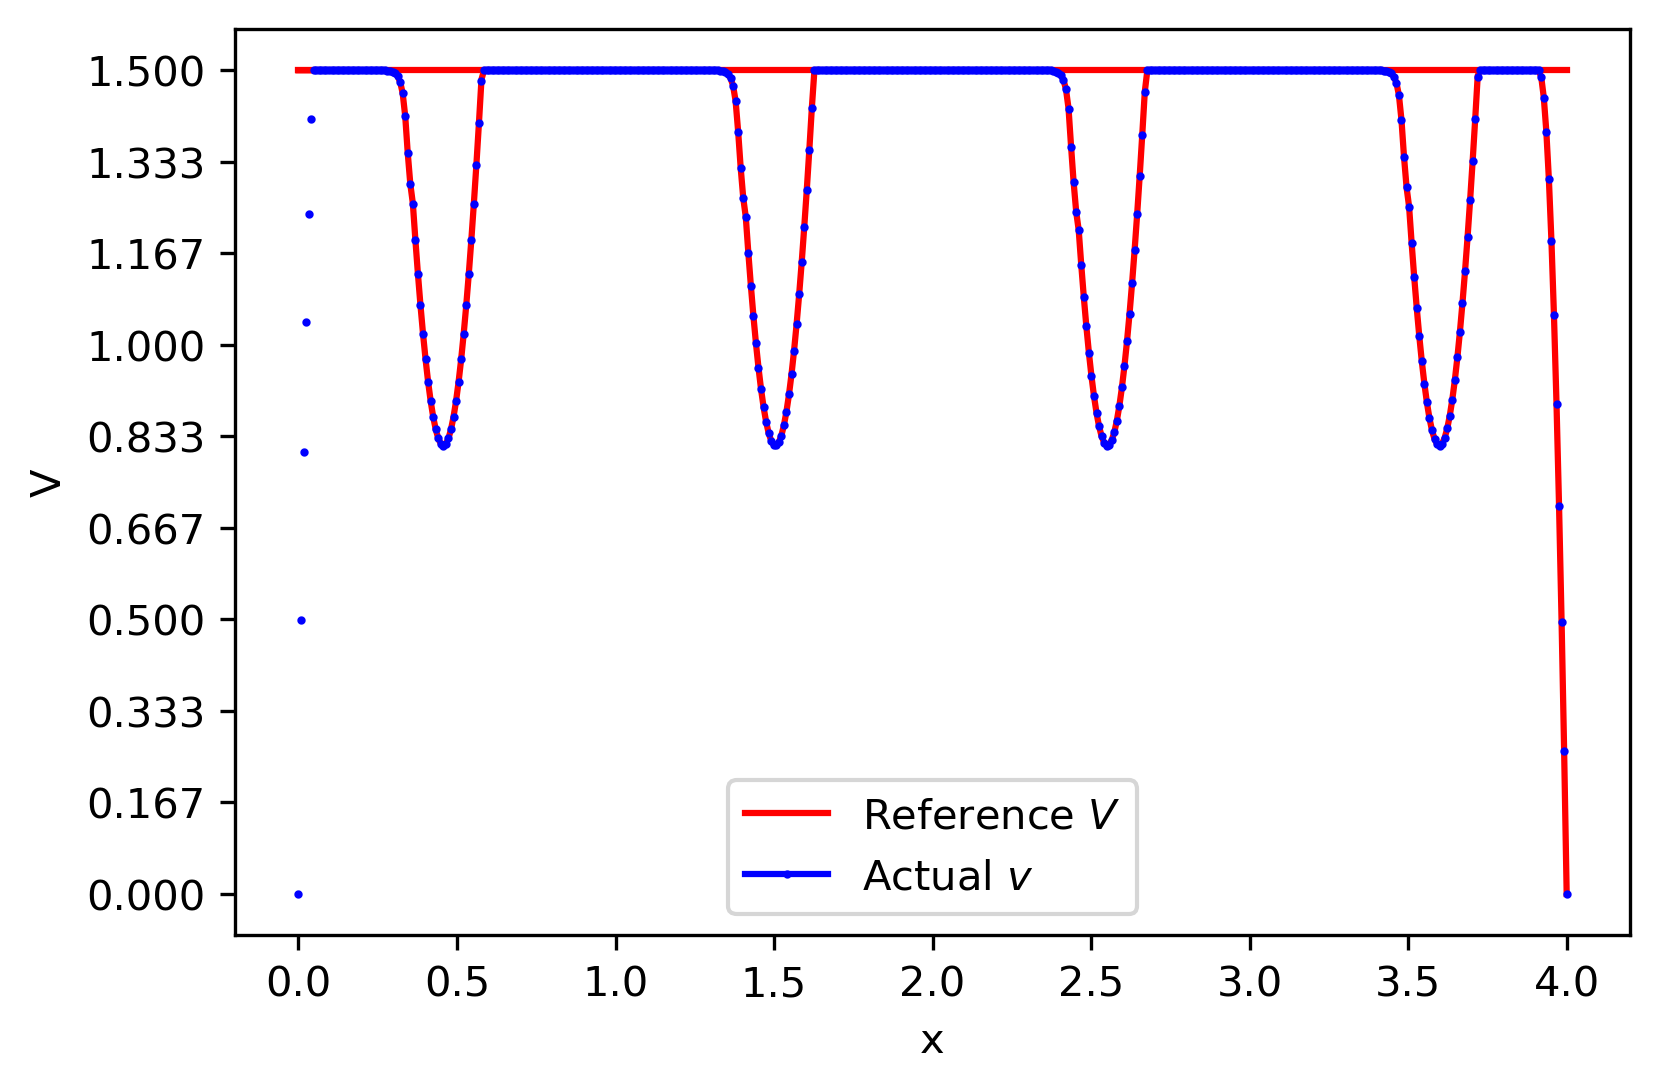

In [46]:
fig, ax = plt.subplots()
xdata = x_i
ydata = [v_max] * steps
fig.set_dpi(300)
ax.set_yticks(np.linspace(0, 1.5, 10))
ax.set_xlabel('x')
ax.set_ylabel('V')
plt.plot(xdata, v_max_i, color='red', label=r'Reference $V$')
plt.plot(xdata, [v_max] * steps, color='red')

for i in range(steps):
    if i == 0:
        plt.plot(xdata[i], v_i[i], marker='o', markersize=1, color='blue', label=r'Actual $v$')
    else:
        plt.plot(xdata[i], v_i[i], marker='o', markersize=1, color='blue')
    
plt.legend()

plt.savefig('vel_res.png', dpi=300)

In [36]:
an_max_i = [v_max_i[i]**2 * k_i[i] for i in range(steps)]

In [37]:
an_i = [v_i[i]**2 * k_i[i] for i in range(steps)]

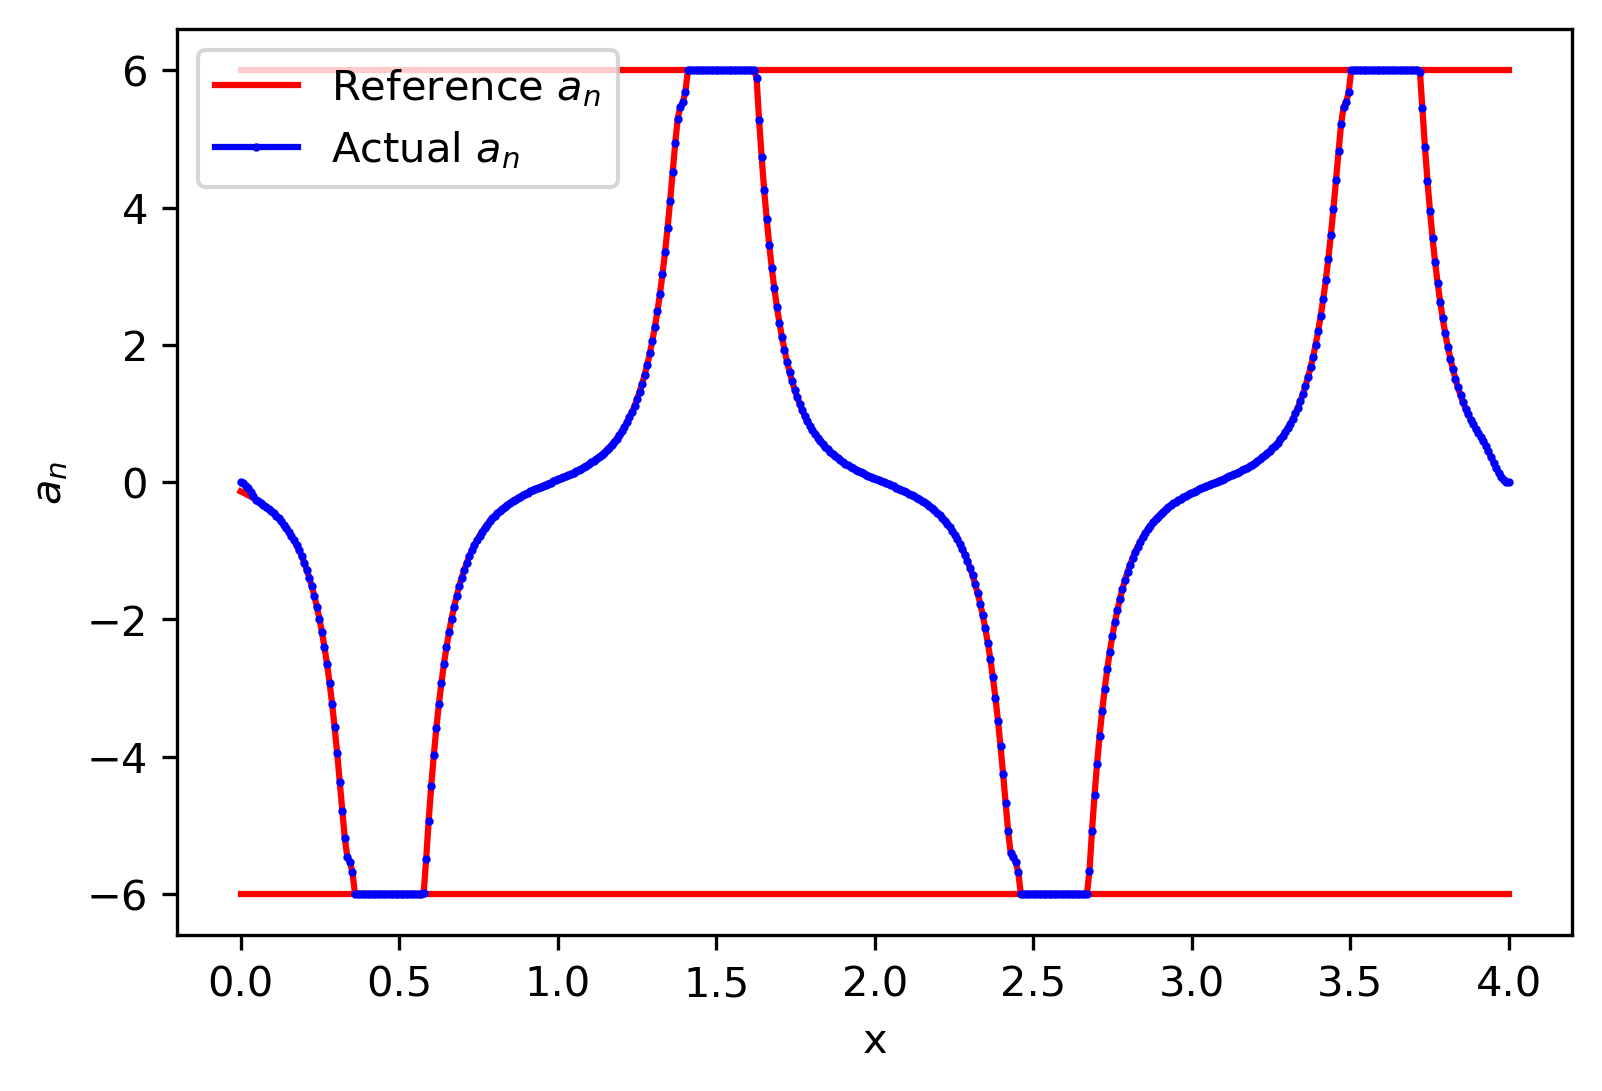

In [52]:
fig, ax = plt.subplots()
xdata = x_i

ax.set_xlabel('x')
ax.set_ylabel(r'$a_{n}$')

fig.set_dpi(300)
plt.plot(xdata, an_max_i, color='red', label=r'Reference $a_n$')
plt.plot(xdata, [a_n_max] * steps, color='red')
plt.plot(xdata, [-a_n_max] * steps, color='red')

for i in range(steps):
    if i == 0:
        plt.plot(xdata[i], an_i[i], marker='o', markersize=1, color='blue', label=r'Actual $a_n$')
    else:
        plt.plot(xdata[i], an_i[i], marker='o', markersize=1, color='blue')

plt.legend()
plt.savefig('an_res.png', dpi=300)

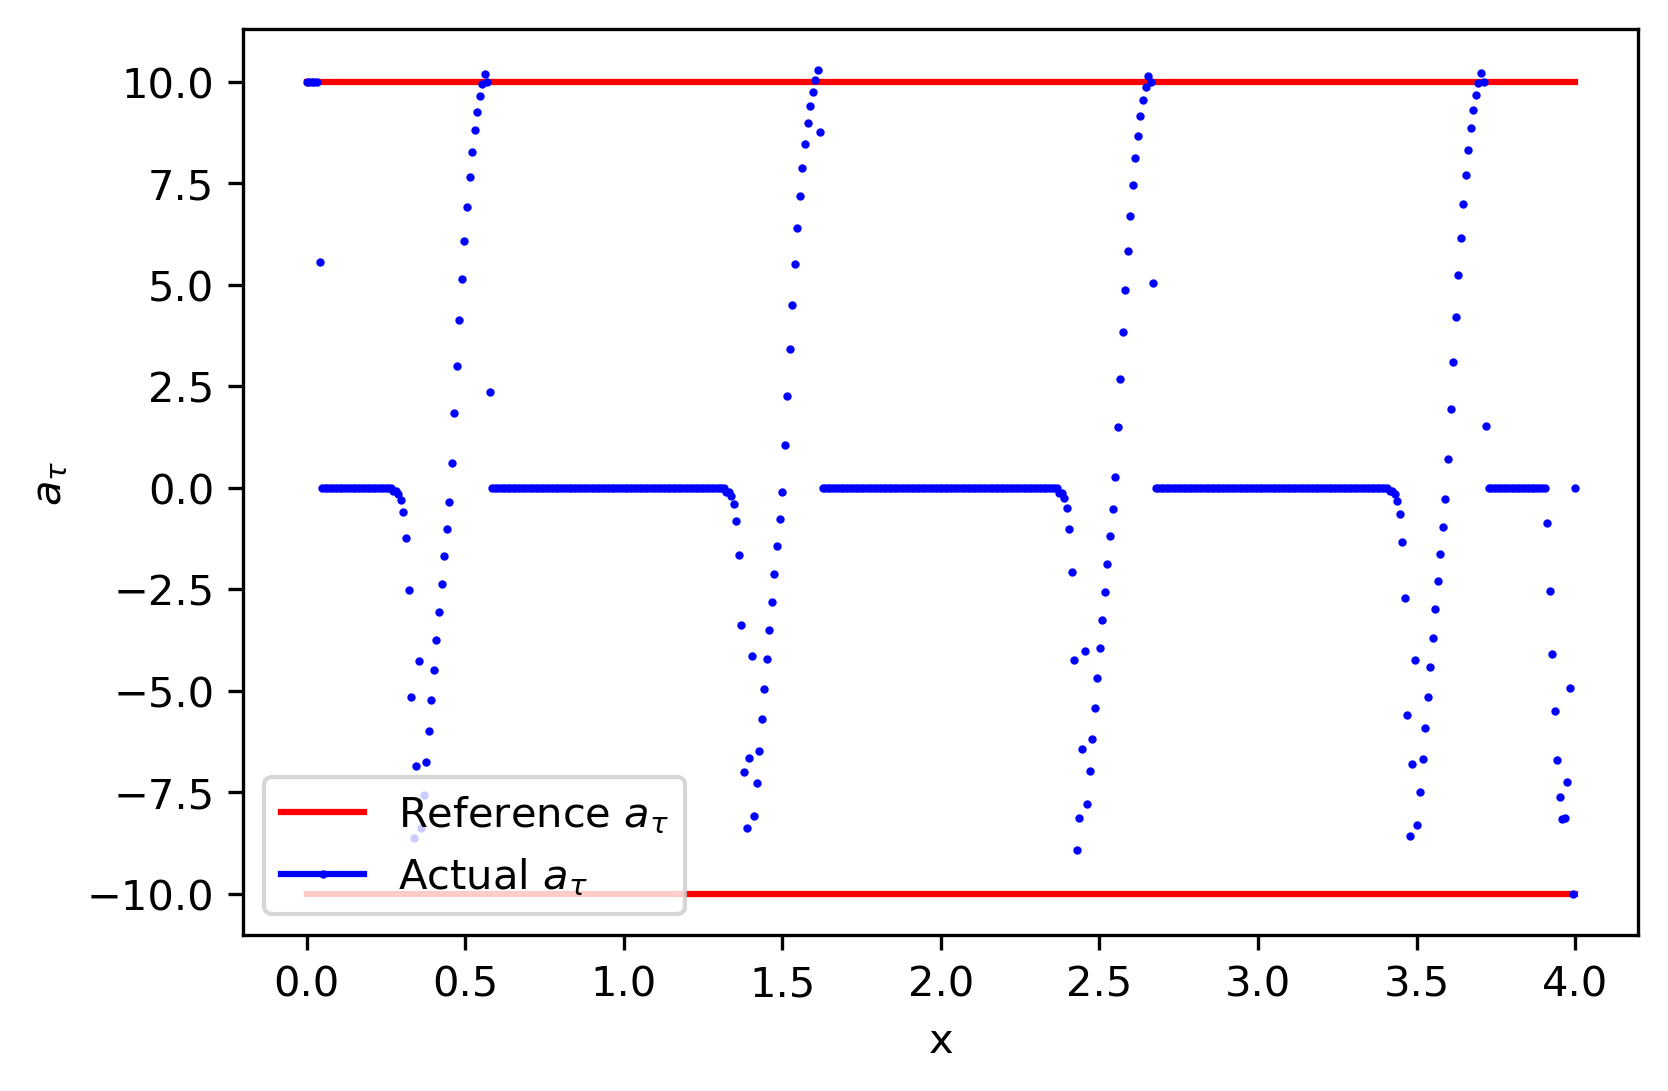

In [51]:
fig, ax = plt.subplots()
xdata = x_i

ax.set_xlabel('x')
ax.set_ylabel(r'$a_{\tau}$')

fig.set_dpi(300)
plt.plot(xdata, [a_t_max] * steps, color='red', label=r'Reference $a_{\tau}}$')
plt.plot(xdata, [-a_t_max] * steps, color='red')


for i in range(steps):
    if i == 0:
        plt.plot(xdata[i], a_i[i], marker='o', markersize=1, color='blue', label=r'Actual $a_{\tau}$')
    else:
        plt.plot(xdata[i], a_i[i], marker='o', markersize=1, color='blue')

plt.legend()
plt.savefig('at_res.png', dpi=300)

In [21]:

class SimPlot:
    fig, ax = None, None

    lines = []
    titles = []
    points = []
    vectors = []
    patches = []

    def __init__(self, xlim, ylim):
        self.fig, self.ax = plt.subplots()
        self.ax.set_xlim(xlim[0], xlim[1])
        self.ax.set_ylim(ylim[0], ylim[1])
        self.ax.set_aspect("equal")

    def plot_lines(self, in_lines, in_colors=[]):
        colors = in_colors + ['black'] * (len(in_lines) - len(in_colors))

        self.lines.extend([
            plt.plot([u[0], v[0]], [u[1], v[1]], color=color)
            for [u, v], color in zip(in_lines, colors)
        ])

    def plot_points(self, in_points, in_sizes=[], in_colors=[]):
        colors = in_colors + ['black'] * (len(in_points) - len(in_colors))
        sizes = in_sizes + [3] * (len(in_points) - len(in_sizes))
        
        self.points.extend([
            plt.plot([x], [y], marker='o', markersize=size, color=color)
            for [x, y], size, color in zip(in_points, sizes, colors)
        ])

    def plot_titles(self, coords, titles, ofx=0, ofy=0):
        self.titles.extend([
            self.ax.text(x + ofx, y + ofy, title)
            for [x, y], title in zip(coords, titles)
        ])

    def plot_vectors(self, vectors_u, vectors_v, titles, scale=1, in_colors=[]):
        colors = in_colors + ['black'] * (len(vectors_u) - len(in_colors))
        self.vectors.extend([
            plt.quiver(float(u[0]), float(u[1]), float(v[0]), float(v[1]), color=color, scale=scale, angles='xy', units='xy', scale_units='xy')
            for u, v, color in zip(vectors_u, vectors_v, colors)
        ])

        self.plot_titles([u + v / scale for u, v in zip(vectors_u, vectors_v)], titles)

    def add_patch(self, patch):
        self.ax.add_patch(patch)
        self.patches.append(patch)
    

    def clear_plot(self):
        while len(self.lines):
            self.lines[-1][0].remove()
            self.lines.pop()

        while len(self.titles):
            self.titles[-1].remove()
            self.titles.pop()

        while len(self.points):
            self.points[-1][0].remove()
            self.points.pop()

        while len(self.vectors):
            self.vectors[-1].remove()
            self.vectors.pop()

        while len(self.patches):
            self.patches[-1].remove()
            self.patches.pop()

In [22]:
def c_rot(vectors, angle, origin = [0, 0]):
        for i in range(len(vectors)):
            vectors[i] = complex(vectors[i][0] - origin[0], vectors[i][1] - origin[1])
            vectors[i] *= np.exp(angle * complex(0, 1))
            vectors[i] = [vectors[i].real + origin[0], vectors[i].imag + origin[1]]
        return vectors

In [27]:
plt.close('all')
simplot = SimPlot([-1, 5], [-3, 3])

xdata = []
ydata = []
ln, = plt.plot([], [], 'b-')
simplot.ax.set_xlabel('x')
simplot.ax.set_ylabel('y')

# animation update on every frame
def update_task1(frame):
    # substitute frame for time variable

    y_prime = float(sp.diff(y).subs(x, x_i[frame]).evalf())
    tau = Point2D(1 / np.sqrt(1 + y_prime**2), y_prime / np.sqrt(1 + y_prime**2))
    norm = Point2D(c_rot([tau], np.pi / 2)[0])
    
    xdata.append(x_i[frame])
    ydata.append(y_i[frame])

    simplot.clear_plot()
    simplot.plot_vectors([Point2D(x_i[frame], y_i[frame])], [v_i[frame] * tau], titles=[r'$\vec{V}$'], in_colors=['black'], scale=2)
    simplot.plot_vectors([Point2D(x_i[frame], y_i[frame])], [an_i[frame] * norm], titles=[r'$\vec{a}_n$'], in_colors=['blue'], scale=10)
    simplot.plot_vectors([Point2D(x_i[frame], y_i[frame])], [a_i[frame] * tau], titles=[r'$\vec{a}_\tau$'], in_colors=['red'], scale=10)

    ln.set_data(xdata, ydata)
    return ln,

anim = FuncAnimation(simplot.fig, update_task1, frames=steps, blit=True)

# save animation to the file
anim.save('sim.gif', dpi=300, writer=PillowWriter(fps=60))
# prevent unclosed plots
plt.close('all')

Point2D(321998583779303/1000000000000000, 946740150222923/1000000000000000) Point2D(-946740150222923/1000000000000000, 321998583779303/1000000000000000)
Point2D(321998583779303/1000000000000000, 946740150222923/1000000000000000) Point2D(-946740150222923/1000000000000000, 321998583779303/1000000000000000)
Point2D(321998583779303/1000000000000000, 946740150222923/1000000000000000) Point2D(-946740150222923/1000000000000000, 321998583779303/1000000000000000)
Point2D(80873837366981/250000000000000, 189245952017223/200000000000000) Point2D(-189245952017223/200000000000000, 80873837366981/250000000000000)
Point2D(325174323356739/1000000000000000, 945654090790859/1000000000000000) Point2D(-945654090790859/1000000000000000, 325174323356739/1000000000000000)
Point2D(163519832926359/500000000000000, 945010612088003/1000000000000000) Point2D(-945010612088003/1000000000000000, 163519832926359/500000000000000)
Point2D(329096041819357/1000000000000000, 472148227588231/500000000000000) Point2D(-472148